In [5]:
%matplotlib inline

import pandas as pd
import numpy as np

import sys
PATH = '/Users/gaetanoantonicchio/Documents/GitHub/DataMining-2'
sys.path.insert(0, PATH) 
# sklearn modules
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier

import plotly.express as px
import matplotlib.pyplot as plt

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

 _______________________________________________
# Years of Rock Classification - 2008 to 2015
## # echonest audio features + duration and listens
 _______________________________________________
### 1. Preprocessing

In [8]:
# load data
rock_df = pd.read_csv('/Users/gaetanoantonicchio/Documents/GitHub/DataMining-2/src/Data (cleaned)/Datasets/rock_year_df.csv')
rock_df.set_index('track_id', inplace=True)
rock_df.drop('genre_top',axis=1, inplace=True)
rock_df.drop('name',axis=1, inplace=True)
rock_df.drop('comments',axis=1, inplace=True)
rock_df.drop('listens',axis=1, inplace=True)


rock_df.head()

acousticness  danceability    energy  instrumentalness  liveness  \
track_id                                                                     
153           0.988306      0.255661  0.979774          0.973006  0.121342   
154           0.970135      0.352946  0.023852          0.957113  0.113261   
155           0.981657      0.142249  0.912122          0.967294  0.363510   
169           0.989141      0.225978  0.722835          0.263076  0.092371   
170           0.886660      0.298518  0.744333          0.920950  0.139587   

          speechiness   tempo   valence  duration  bit_rate  year  \
track_id                                                            
153          0.051740  90.241  0.034018       405       256  2008   
154          0.032177  53.758  0.035632       319       256  2008   
155          0.087527  91.912  0.034325       756       192  2008   
169          0.053406  94.322  0.028347       144       192  2008   
170          0.088781  97.880  0.073548       181       192  2008   

          song_hotttnesss  artist_hotttnesss  artist_familiarity  
track_id                                                          
153              0.044300           0.274455            0.173315  
154              0.070213           0.274455            0.173315  
155              0.000000           0.274455            0.173315  
169              0.039431           0.287989            0.162622  
170              0.000000           0.287989            0.162622

In [9]:
rock_df.year.value_counts()

2009    1036
2008    1005
2010     687
2011     606
2012     213
2013     142
2014     132
2015      71
Name: year, dtype: int64

In [10]:
rock_df.shape

(3892, 14)

In [11]:
pd.concat([rock_df.year.value_counts(),
                round(rock_df.year.value_counts(normalize=True).mul(100),2)],axis=1, keys=('counts','percentage (%)'))

counts  percentage (%)
2009    1036           26.62
2008    1005           25.82
2010     687           17.65
2011     606           15.57
2012     213            5.47
2013     142            3.65
2014     132            3.39
2015      71            1.82

In [12]:
rock_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3892 entries, 153 to 124186
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   acousticness        3892 non-null   float64
 1   danceability        3892 non-null   float64
 2   energy              3892 non-null   float64
 3   instrumentalness    3892 non-null   float64
 4   liveness            3892 non-null   float64
 5   speechiness         3892 non-null   float64
 6   tempo               3892 non-null   float64
 7   valence             3892 non-null   float64
 8   duration            3892 non-null   int64  
 9   bit_rate            3892 non-null   int64  
 10  year                3892 non-null   int64  
 11  song_hotttnesss     3892 non-null   float64
 12  artist_hotttnesss   3892 non-null   float64
 13  artist_familiarity  3892 non-null   float64
dtypes: float64(11), int64(3)
memory usage: 456.1 KB


In [13]:
# convert year from integer to string
rock_df.year = rock_df.year.astype(str)

In [14]:
# encoding labels
le = preprocessing.LabelEncoder()
rock_df['year'] = le.fit_transform(rock_df['year'])
rock_df.head()

acousticness  danceability    energy  instrumentalness  liveness  \
track_id                                                                     
153           0.988306      0.255661  0.979774          0.973006  0.121342   
154           0.970135      0.352946  0.023852          0.957113  0.113261   
155           0.981657      0.142249  0.912122          0.967294  0.363510   
169           0.989141      0.225978  0.722835          0.263076  0.092371   
170           0.886660      0.298518  0.744333          0.920950  0.139587   

          speechiness   tempo   valence  duration  bit_rate  year  \
track_id                                                            
153          0.051740  90.241  0.034018       405       256     0   
154          0.032177  53.758  0.035632       319       256     0   
155          0.087527  91.912  0.034325       756       192     0   
169          0.053406  94.322  0.028347       144       192     0   
170          0.088781  97.880  0.073548       181       192     0   

          song_hotttnesss  artist_hotttnesss  artist_familiarity  
track_id                                                          
153              0.044300           0.274455            0.173315  
154              0.070213           0.274455            0.173315  
155              0.000000           0.274455            0.173315  
169              0.039431           0.287989            0.162622  
170              0.000000           0.287989            0.162622

In [15]:
print('Legend:\n0: 2008\n1: 2009\n2: 2010\n3: 2011\n4: 2012\n5: 2013 \n6: 2014\n7: 2015')
rock_df.year.value_counts()

Legend:
0: 2008
1: 2009
2: 2010
3: 2011
4: 2012
5: 2013 
6: 2014
7: 2015


1    1036
0    1005
2     687
3     606
4     213
5     142
6     132
7      71
Name: year, dtype: int64

In [16]:
# detach target col
labels = rock_df[['year']]
labels.reset_index(drop=True, inplace=True)
labels = labels['year']

In [18]:
# remove labels from dataframe
rock_df.drop('year', axis=1, inplace=True)

In [19]:
# normalize the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(rock_df)

# 2. PCA on normalized data (scaled_features)
## 2.1 Determine optimal number of components
### a) scree-plot

Text(0.5, 0, 'Principal Component #')

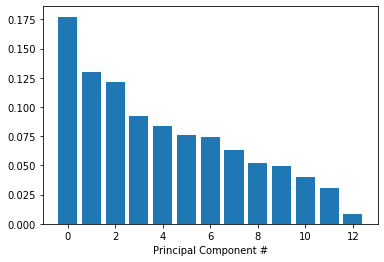

In [20]:
pca = PCA()
pca.fit(scaled_features)
# get explained variance ratios from PCA using all features
exp_variance = pca.explained_variance_ratio_
# plot explained variance
fig, ax= plt.subplots()
ax.bar(range(pca.n_components_),exp_variance)
ax.set_xlabel('Principal Component #')

### b) cumulative explained variance plot

Optimal number of components: 9
Explained variation per principal component:
[0.17723237 0.12970745 0.12148905 0.09249354 0.08387941 0.0763779
 0.07412343 0.06325006 0.05244382 0.04927265 0.04035725 0.03073329
 0.00863979]


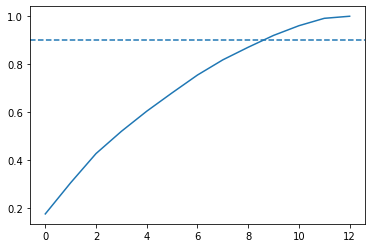

In [21]:
# calculate the cumulative explained variance
cum_exp_var = np.cumsum(exp_variance)

# plot the cumulative explained variance and draw a dashed line at 0.9\
# This line indicates how much variance (information) we want to retain
fig, ax= plt.subplots()
ax.plot(cum_exp_var)
ax.axhline(y=0.9, linestyle='--')

# find index where cum_exp_var exceeds 0.9 and adding 1 to that index to get the num of components
n_components = ((np.where(cum_exp_var > 0.9))[0][0])
print(f"Optimal number of components: {n_components}")
print(f"Explained variation per principal component:\n{pca.explained_variance_ratio_}")
# perform PCA with the chosen number of components and project data onto components
pca = PCA(n_components,random_state=42)
pca.fit(scaled_features)
pca_proj = pca.transform(scaled_features)

## 2.2 Plot PCA in 2D

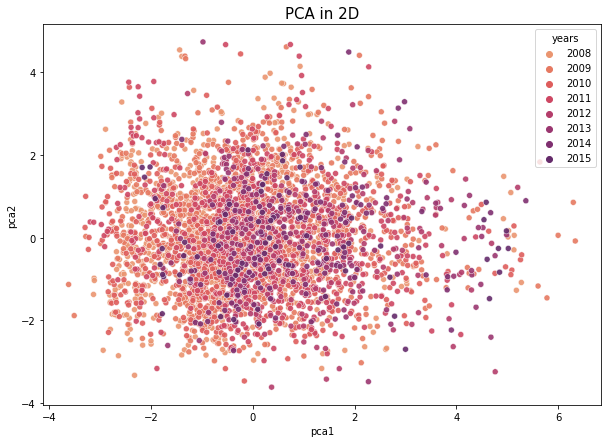

In [22]:
# generating df for plotting PCA
df = pd.DataFrame()
df['pca1'] = pca_proj[:,0]
df['pca2'] = pca_proj[:,1]
df['pca3'] = pca_proj[:,2]
df['years'] = le.inverse_transform(labels)

# plot scatter of PCA
plt.figure(figsize=(10,7))
sns.scatterplot(
    x="pca1", y="pca2",
    hue='years',
    palette = 'flare',
    data=df,
    legend='full',
    alpha=0.9
)
plt.title("PCA in 2D", fontsize= 15)
plt.show()

### 2.3 Plot PCA in 3D

In [23]:
# 3D PCA
#total_var = pca.explained_variance_ratio_.sum() * 100
fig = px.scatter_3d(
    df, x='pca1', y='pca2', z='pca3', color='years',
    #title=f'Total Explained Variance: {total_var:.2f}%',
    #labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.update_layout(legend=dict(
    orientation="v",
    yanchor="bottom",
    y=1,
    xanchor="right",
    x=0.6
),width=700, height=700, scene_camera_eye_z=0.8)
fig.show()


# 3. Split data for classification

In [24]:
# shuffle and split into development set and internal test set:
# (PCA)
Xpca_develop, Xpca_test, y_develop_pca, y_test_pca = train_test_split(
pca_proj, labels, test_size=0.30, random_state=42, stratify=labels)

# (split without PCA)
X_develop, X_test, y_develop, y_test = train_test_split(
scaled_features, labels, test_size=0.30, random_state=42,stratify= labels)

In [25]:
# check partitions
print(f"Legend:\n0: 2008\n1: 2009\n2: 2010\n3: 2011\n4: 2012\n5: 2013 \n6: 2014\n7: 2015\n\n\
***PCA***\nDevelopment set:\n{y_develop_pca.value_counts()}\n\nInternal Test:\
\n{y_test_pca.value_counts()}\n\n\-----------------\n\***No-PCA***\nDevelopment set:\n{y_develop.value_counts()}\n\nInternal Test:\n{y_test.value_counts()}")

Legend:
0: 2008
1: 2009
2: 2010
3: 2011
4: 2012
5: 2013 
6: 2014
7: 2015

***PCA***
Development set:
1    725
0    704
2    481
3    424
4    149
5     99
6     92
7     50
Name: year, dtype: int64

Internal Test:
1    311
0    301
2    206
3    182
4     64
5     43
6     40
7     21
Name: year, dtype: int64

\-----------------
\***No-PCA***
Development set:
1    725
0    704
2    481
3    424
4    149
5     99
6     92
7     50
Name: year, dtype: int64

Internal Test:
1    311
0    301
2    206
3    182
4     64
5     43
6     40
7     21
Name: year, dtype: int64


# 4. Decision Tree
### a) Unbalanced - without PCA

#### - Validation Schema: coarse grid-search with 5 fold CV
We adopt a 10 fold cross validation repeated 10 times and then averaged, in order to reduce the variance of the model.

In [43]:
# search parameters
param_grid = {
               "max_depth": [4,5,6,7,8,9,10,15],
               "min_samples_leaf": [10,15,20,35,40,50,60,75],
               "min_samples_split":[5,10,15,20,30,40,50],
               "criterion": ["gini", "entropy"]
             }
# instantiate a model
dtc = DecisionTreeClassifier()
rep_kfold = RepeatedKFold(n_splits=5, n_repeats=1, random_state=42)
clf = GridSearchCV(dtc, cv =rep_kfold , param_grid=param_grid, n_jobs=3, verbose=True, scoring='balanced_accuracy')
clf.fit(X_develop, y_develop)
# display top 3 models
print(f"best parameters:\n{clf.best_params_}\naccuracy: {clf.best_score_}")

Fitting 5 folds for each of 896 candidates, totalling 4480 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  74 tasks      | elapsed:    6.0s
[Parallel(n_jobs=3)]: Done 674 tasks      | elapsed:   13.9s
[Parallel(n_jobs=3)]: Done 1674 tasks      | elapsed:   29.1s
[Parallel(n_jobs=3)]: Done 3074 tasks      | elapsed:   57.7s


best parameters:
{'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 10, 'min_samples_split': 5}
accuracy: 0.3518902603739143


[Parallel(n_jobs=3)]: Done 4480 out of 4480 | elapsed:  1.6min finished


#### - Train and predict
The model is retrained on the full development set.

The prediction will be saved as:
- y_pred_dtc

The roc curve will be saved as:
- roc_auc0

The false and true positive rates will be saved as:
- fpr0
- tpr0

In [44]:
# train and fit
dtc = DecisionTreeClassifier(criterion= 'entropy',max_depth=15, min_samples_leaf= 10, min_samples_split=5)
dtc.fit(X_develop,y_develop)
# predict on internal test set
y_pred_dtc = dtc.predict(X_test)

# display metrics
print('Accuracy %s' % accuracy_score(y_test, y_pred_dtc))
print('F1-score %s' % f1_score(y_test, y_pred_dtc, average=None))
print(classification_report(y_test, y_pred_dtc))

Accuracy 0.4965753424657534
F1-score [0.6105919  0.55572519 0.44221106 0.40935673 0.34645669 0.27160494
 0.24561404 0.23529412]
              precision    recall  f1-score   support

           0       0.57      0.65      0.61       301
           1       0.53      0.59      0.56       311
           2       0.46      0.43      0.44       206
           3       0.44      0.38      0.41       182
           4       0.35      0.34      0.35        64
           5       0.29      0.26      0.27        43
           6       0.41      0.17      0.25        40
           7       0.31      0.19      0.24        21

    accuracy                           0.50      1168
   macro avg       0.42      0.38      0.39      1168
weighted avg       0.49      0.50      0.49      1168



#### Confusion Matrix

[[196  59  21  20   3   2   0   0]
 [ 66 182  33  14   7   4   2   3]
 [ 39  41  88  23   8   2   5   0]
 [ 27  39  33  70   5   7   1   0]
 [  4  10   8   9  22   8   2   1]
 [  5   5   2   8   8  11   0   4]
 [  2   6   6   7   8   3   7   1]
 [  2   2   1   9   2   1   0   4]]


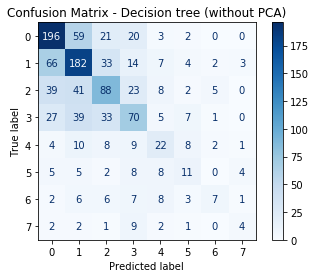

In [45]:
# confusion matrix - Internal Test

cm = plot_confusion_matrix(dtc,X_test,y_test,
                            cmap = plt.cm.Blues)
cm.ax_.set_title('Confusion Matrix - Decision tree (without PCA)')
print(cm.confusion_matrix)
plt.show()

### b) Unbalanced - with PCA
#### Validation schema:  repeated 5 fold cross validation - grid search

In [48]:
# model
dtc_pca = DecisionTreeClassifier()
rep_kfold = RepeatedKFold(n_splits=5, n_repeats=1, random_state=42)
clf = GridSearchCV(dtc, cv =rep_kfold , param_grid=param_grid, n_jobs=3, verbose=True,scoring='f1_weighted')

clf.fit(Xpca_develop, y_develop_pca)
print(f"best parameters:\n{clf.best_params_}\naccuracy: {clf.best_score_}")

Fitting 5 folds for each of 896 candidates, totalling 4480 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done 146 tasks      | elapsed:    1.7s
[Parallel(n_jobs=3)]: Done 746 tasks      | elapsed:    9.5s
[Parallel(n_jobs=3)]: Done 1746 tasks      | elapsed:   22.5s
[Parallel(n_jobs=3)]: Done 3146 tasks      | elapsed:   50.1s


best parameters:
{'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 20, 'min_samples_split': 50}
accuracy: 0.3490820243337468


[Parallel(n_jobs=3)]: Done 4480 out of 4480 | elapsed:  1.4min finished


#### - Train and predict
The model is retrained on the full development set.

The prediction will be saved as:
- y_pred_dtc_pca

The roc curve will be saved as:
- roc_auc1

The false and true positive rates will be saved as:
- fpr1
- tpr1

In [49]:
dtc_pca = DecisionTreeClassifier(criterion= 'gini',max_depth=8, min_samples_leaf= 20, min_samples_split= 50)
dtc_pca.fit(Xpca_develop,y_develop_pca)

y_pred_dtc_pca = dtc_pca.predict(Xpca_test)

print('Accuracy %s' % accuracy_score(y_test_pca, y_pred_dtc_pca))
print('F1-score %s' % f1_score(y_test_pca, y_pred_dtc_pca, average=None))
print(classification_report(y_test_pca, y_pred_dtc_pca))

Accuracy 0.3467465753424658
F1-score [0.47524752 0.37195994 0.28287841 0.17490494 0.26086957 0.225
 0.125      0.        ]
              precision    recall  f1-score   support

           0       0.41      0.56      0.48       301
           1       0.34      0.42      0.37       311
           2       0.29      0.28      0.28       206
           3       0.28      0.13      0.17       182
           4       0.29      0.23      0.26        64
           5       0.24      0.21      0.23        43
           6       0.38      0.07      0.12        40
           7       0.00      0.00      0.00        21

    accuracy                           0.35      1168
   macro avg       0.28      0.24      0.24      1168
weighted avg       0.33      0.35      0.33      1168



#### Confusion matrix

[[163  85  40  10   2   1   0   0]
 [113 121  53  14   3   7   0   0]
 [ 59  61  60  15   5   6   0   0]
 [ 47  49  44  25   8   9   0   0]
 [  5   9  10  12  11  14   3   0]
 [  5   9   1  10   5  11   2   0]
 [  6   8   6   3   5   9   3   0]
 [  5   4   2   4   2   4   0   0]]


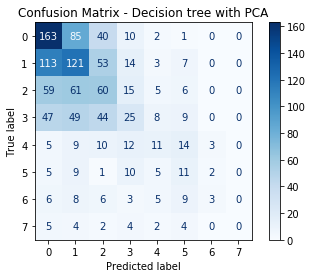

In [41]:
# confusion matrix Decision tree with PCA
cm_pca = plot_confusion_matrix(dtc_pca,Xpca_test,y_test_pca,
                            cmap = plt.cm.Blues)
cm_pca.ax_.set_title('Confusion Matrix - Decision tree with PCA')
print(cm_pca.confusion_matrix)
plt.show()

# 5. KNN
### a) Unbalanced - without PCA

#### Validation schema: coarse grid search with repeated 5 fold cross validation

In [35]:
# range of k to try - find a good range of k
k_range = {"n_neighbors":[x for x in range(2, 50)]}

knn = KNeighborsClassifier()
rep_kfold = RepeatedKFold(n_splits=5, n_repeats=1, random_state=42)
clf = GridSearchCV(knn, param_grid= k_range, cv=rep_kfold )
clf.fit(X_develop, y_develop)
print(f"best parameters:\n{clf.best_params_}\naccuracy: {clf.best_score_}")

best parameters:
{'n_neighbors': 4}
accuracy: 0.45998381003777666


#### Train and predict

In [36]:
knn =  KNeighborsClassifier(n_neighbors = 4)
# retrain knn on the whole development set
knn.fit(X_develop, y_develop)
# predict target variable
y_pred_knn0 = knn.predict(X_test)

# display classification report
print(classification_report(y_test, y_pred_knn0))

              precision    recall  f1-score   support

           0       0.48      0.68      0.56       301
           1       0.47      0.48      0.47       311
           2       0.50      0.39      0.44       206
           3       0.38      0.31      0.34       182
           4       0.51      0.39      0.44        64
           5       0.53      0.42      0.47        43
           6       0.48      0.25      0.33        40
           7       0.71      0.24      0.36        21

    accuracy                           0.47      1168
   macro avg       0.51      0.39      0.43      1168
weighted avg       0.47      0.47      0.46      1168



#### Confusion matrix

[[206  59  19  15   1   0   1   0]
 [102 149  29  23   3   2   3   0]
 [ 54  43  80  19   4   2   4   0]
 [ 46  48  20  56   6   4   1   1]
 [  9   6   6  13  25   5   0   0]
 [  5   5   1   8   3  18   2   1]
 [  5   6   4   7   5   3  10   0]
 [  5   3   1   5   2   0   0   5]]


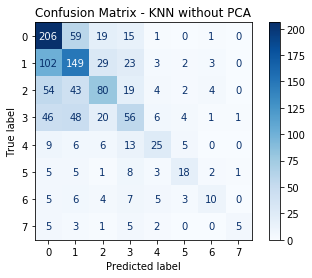

In [37]:
# confusion matrix KNN - Internal test
cm_knn = plot_confusion_matrix(knn,X_test,y_test,
                            cmap = plt.cm.Blues)
cm_knn.ax_.set_title('Confusion Matrix - KNN without PCA')
print(cm_knn.confusion_matrix)
plt.show()

### b) Unbalanced - with PCA

#### Validation schema: coarse grid search with repeated 5 fold cross validation

In [38]:
# range of k to try - find a good range of k
k_range = {"n_neighbors":[x for x in range(2, 50)]}

knn = KNeighborsClassifier()
rep_kfold = RepeatedKFold(n_splits=5, n_repeats=1, random_state=42)
clf = GridSearchCV(knn, param_grid= k_range, cv=rep_kfold )
clf.fit(Xpca_develop, y_develop_pca)
print(f"best parameters:\n{clf.best_params_}\naccuracy: {clf.best_score_}")


best parameters:
{'n_neighbors': 10}
accuracy: 0.4104303831624393


#### Train and predict

In [39]:
knn_pca =  KNeighborsClassifier(n_neighbors = 10)
# retrain knn on the whole development set
knn_pca.fit(Xpca_develop, y_develop_pca)
# predict target variable
y_pred_knn1 = knn_pca.predict(Xpca_test)
# display classification report
print(classification_report(y_test_pca, y_pred_knn1))

              precision    recall  f1-score   support

           0       0.47      0.69      0.56       301
           1       0.41      0.48      0.44       311
           2       0.45      0.33      0.38       206
           3       0.31      0.20      0.24       182
           4       0.41      0.34      0.37        64
           5       0.36      0.23      0.28        43
           6       0.44      0.17      0.25        40
           7       0.00      0.00      0.00        21

    accuracy                           0.43      1168
   macro avg       0.36      0.31      0.32      1168
weighted avg       0.41      0.43      0.41      1168



#### Confusion matrix

[[208  59  13  17   2   1   1   0]
 [110 149  32  12   3   3   2   0]
 [ 57  52  69  19   6   1   2   0]
 [ 44  64  26  36   7   5   0   0]
 [  7  12   6  13  22   2   1   1]
 [  5   4   2  10  10  10   2   0]
 [  5  12   5   6   2   3   7   0]
 [  3   8   2   2   2   3   1   0]]


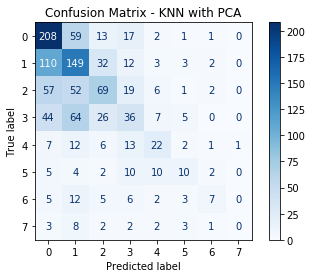

In [42]:
cm_knn_pca = plot_confusion_matrix(knn_pca,Xpca_test,y_test_pca,
                            cmap = plt.cm.Blues)
cm_knn_pca.ax_.set_title('Confusion Matrix - KNN with PCA')
print(cm_knn_pca.confusion_matrix)
plt.show()
